## Concrete Strength Prediction

Objective: To predict the concrete strength using the data available in file concrete_data.xls. Apply feature engineering and model tuning to obtain 80% to 95% of R2score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from scipy.stats import randint as sp_randint
%matplotlib inline

In [2]:
# Happy to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("concrete.csv")
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


### Exploring Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [6]:
df.isnull().sum()
#We don't have any empty values

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

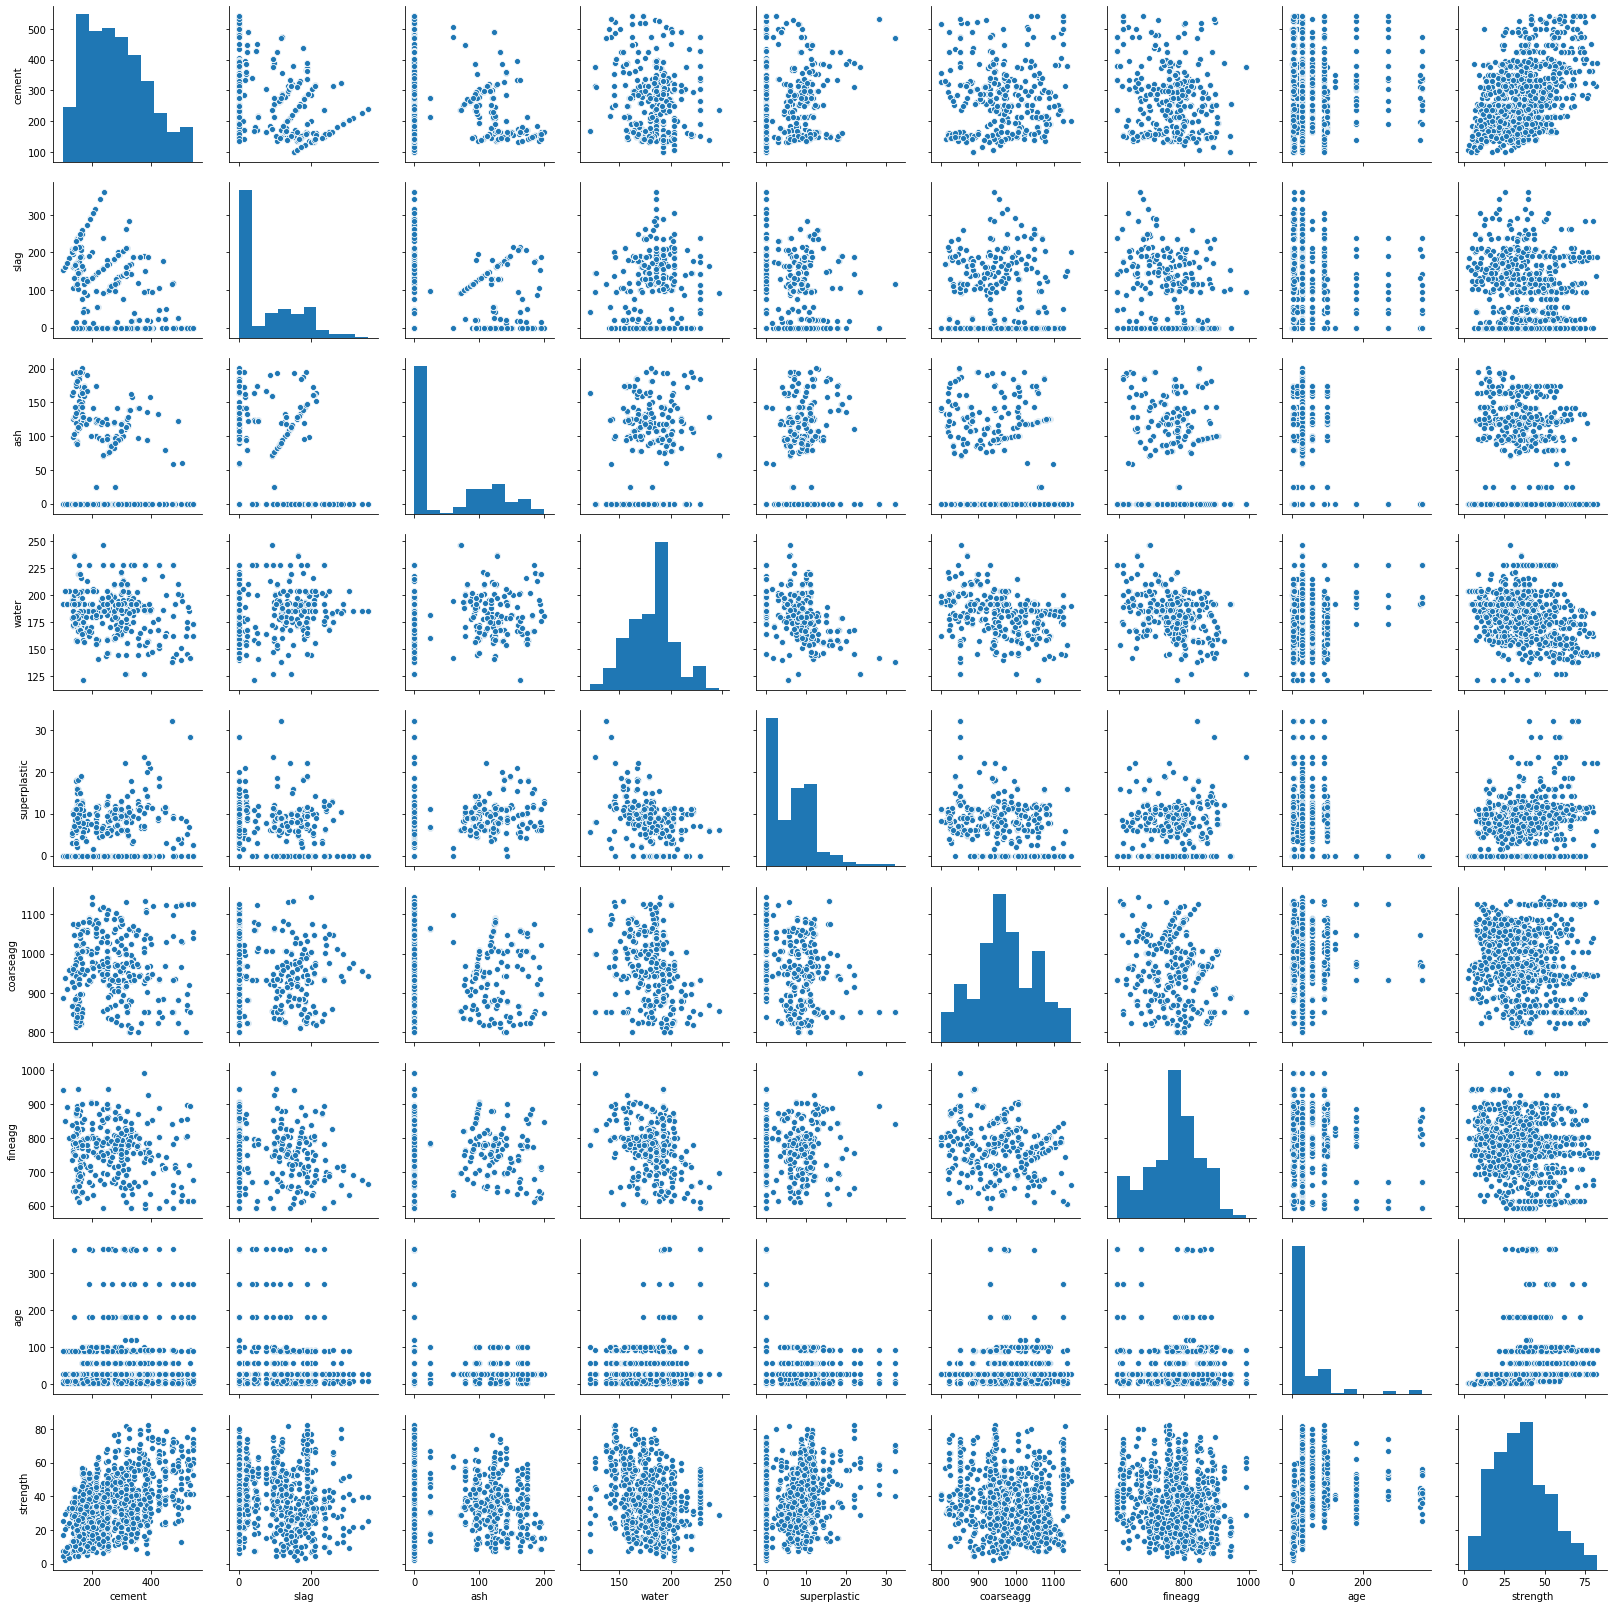

In [7]:
#Lets do a pairplot between variables and check if there is something interesting
sns.pairplot(df)

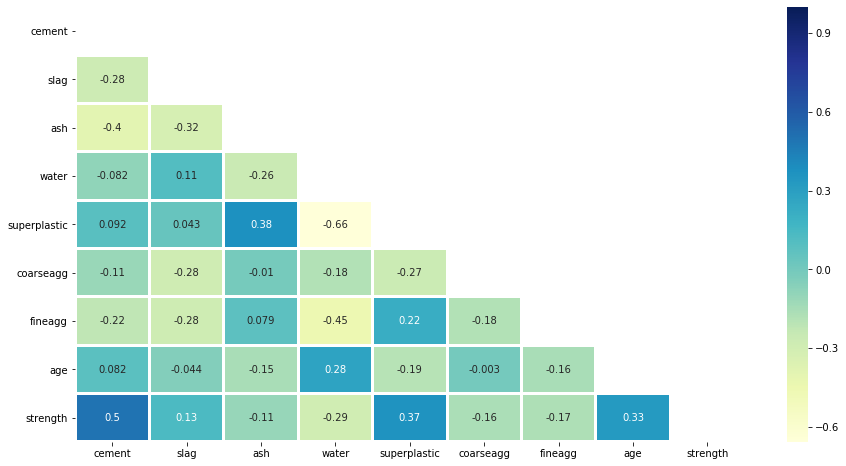

In [8]:
#How is the correlation betwen variables?
corr = df.corr()
plt.figure(figsize=(15,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(),annot=True,linewidth=2,cmap="YlGnBu", mask=mask)

#Strong correlation between cement-strength and superplastic-water,maybe age will be important too

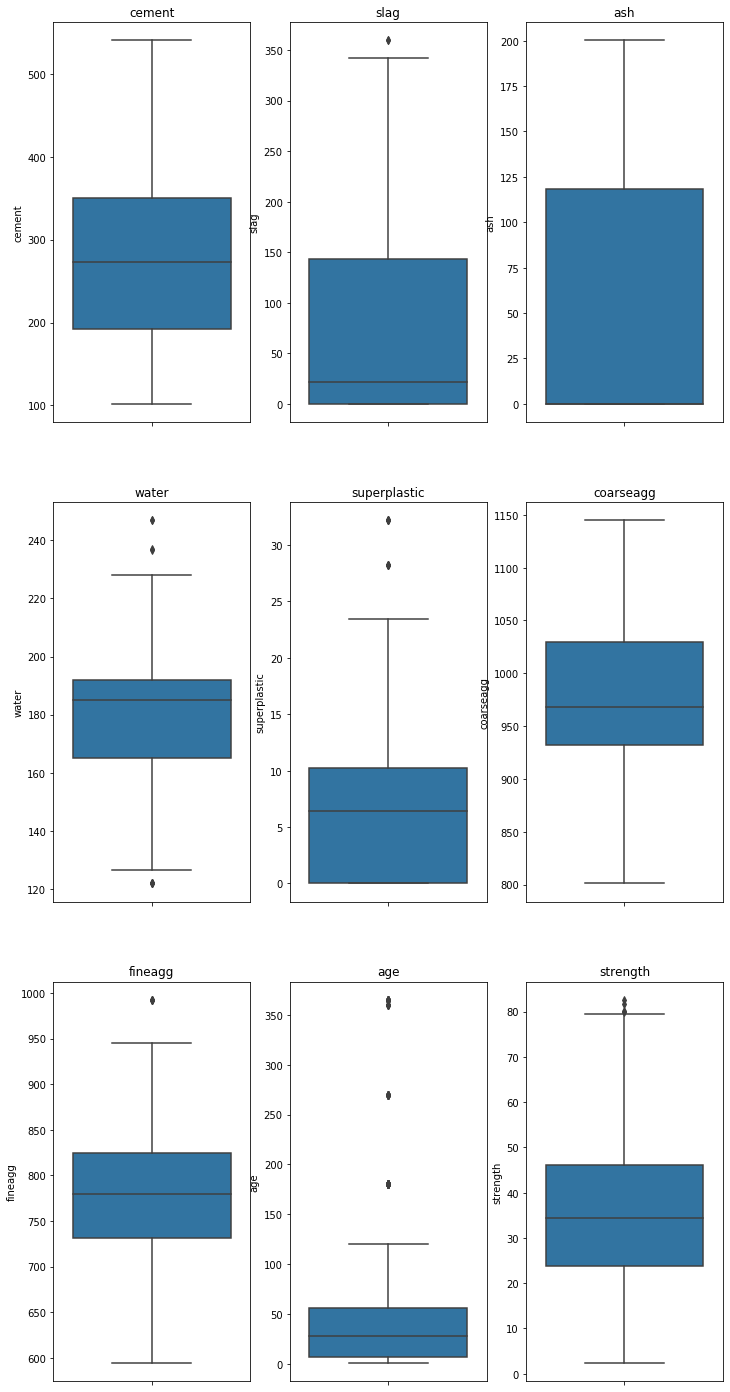

In [9]:
#Find outliers for all columns
cols = df.columns
plt.figure(figsize=(12,25))
for i,j in itertools.zip_longest(cols,range(len(cols))):
    plt.subplot(3,3,j+1)
    ax = sns.boxplot( y = df[i])
    ax.set_title(i)

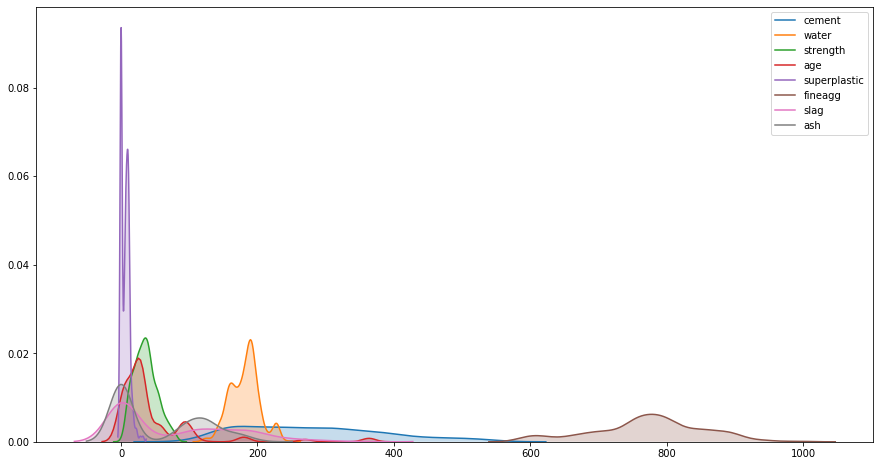

In [10]:
ys = ['cement', 'water','strength','age','superplastic', 'fineagg', 'slag', 'ash']
plt.figure(figsize=(15,8))
for y in ys:
    sns.kdeplot(df[y], shade=True)

In [11]:
#maybe we can convert age from days into months
def months(days):
    months = round(days/30)
    if months < 1:
        months = 1
    return months
df["months"] = df.apply(lambda df:months(df['age']), axis=1)

In [12]:
#we can add another strenght column to make it a classification problem?
def strength(strength):
    #all above mean is 1 and below is 0
    strg = 0
    if strength > 35:
        strg = 1
    return strg
df["strg"] =  df.apply(lambda df:strength(df['strength']), axis=1)

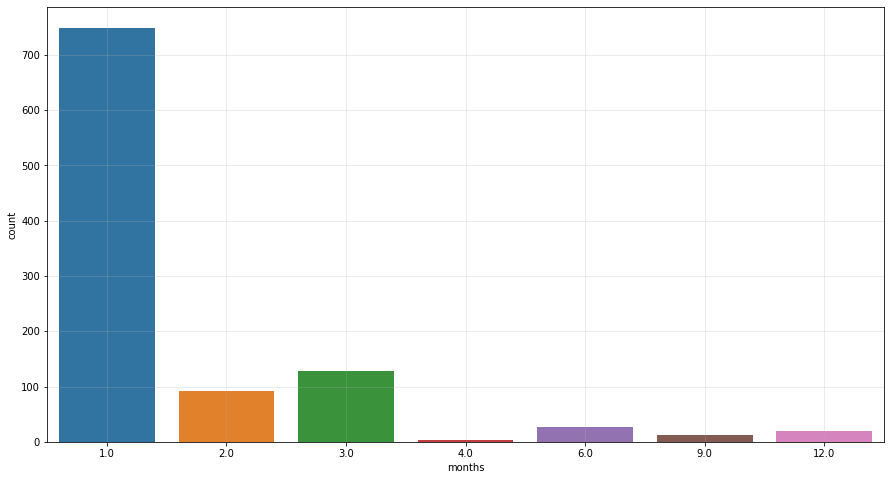

In [13]:
#and lets graph this new information
plt.figure(figsize=(15,8))
ax = sns.countplot(df["months"])
ax.set_facecolor("white")
plt.grid(True,alpha=.3)
plt.show()

# ok almost all have age of 1 month

### Split the data and prepare the model

In [14]:
df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,months,strg
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1.0,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1.0,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1.0,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1.0,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,1.0,0
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30,1.0,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,1.0,1
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06,9.0,1


In [15]:
X = df.drop("strength",axis=1)
y = df["strength"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.2)

### Linear Regression

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
print("Root mean squared error for Linear Regresion:",np.sqrt(mean_squared_error(y_test,lr_prediction)))
print("Score linear regresion:", lr.score(X_test, y_test))

Root mean squared error for Linear Regresion: 6.436202594610567
Score linear regresion: 0.8593241629847709


In [17]:
#Cross validation score for Linear Regression
cross_val = cross_val_score(lr,X_train,y_train,cv=50,scoring="neg_mean_squared_error")
print ("cv-mean :",cross_val.mean())
print ("cv-std  :",cross_val.std())
print ("cv-max  :",cross_val.max())
print ("cv-min  :",cross_val.min())

cv-mean : -40.83450465682793
cv-std  : 15.489317290219988
cv-max  : -9.69346409392663
cv-min  : -81.97171287502253


### Feature selection

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
x_ft = X_train.drop("months", axis=1)
sfmodel = sfs(LinearRegression(), k_features=5, forward=True, scoring='r2', cv=5)
sfmodel.fit(x_ft, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=5,
                          scoring='r2')

In [19]:
print([x_ft.columns[i] for i in sfmodel.k_feature_idx_])
## as expected we can use this columns to improve the performance of the model

['cement', 'slag', 'water', 'age', 'strg']


### Create the model and tunning
Im going to use 3 Lasso. Ridge, Random Forest and AdaBoost

In [20]:
#lets define a wrapper function for all the algorithms
def process(algorithm, obj, xtrain, ytrain, xtest, ytest, crossval=50):
    data={}
    data["algorithm"] = algorithm
    try:
        obj.fit(xtrain, ytrain)
        prediction = obj.predict(xtest)
        tn, fp, fn, tp = confusion_matrix(ytest,prediction).ravel()
        data["rootmeansqerror"] = np.sqrt(mean_squared_error(ytest,prediction))
        df_pred = pd.DataFrame(prediction)
        cross_val = cross_val_score(obj,xtrain,ytrain,cv=crossval,scoring="neg_mean_squared_error")
        data["cv-mean"] = cross_val.mean()
        data["cv-std"] = cross_val.std()
        data["cv-min"] = cross_val.min()
        data["cv-max"] = cross_val.max()
        data["score"] = obj.score(xtest, ytest)
        data["TrueNegative"] = tn
        data["FalsePositive"] = fp
        data["FalseNegative"] = fn
        data["TruePositive"] = tp
        data["recall"] = round(tp/(tp+fn), 3)
        data["precision"] = round(tp/(tp+fp), 3)
        data["specificity"] = round(tn/(tn+fp),3)
    except:
        pass
    return data

In [21]:
algorithms = [{"Name": "DecisionTreeClassifier", "Value": DecisionTreeClassifier()},
              {"Name": "AdaBoostClassifier", "Value": AdaBoostClassifier()},
              {"Name": "RandomForestClassifier", "Value": RandomForestClassifier(random_state=1)},
              {"Name": "LogisticRegression", "Value": LogisticRegression(solver='liblinear', random_state=0)}
              
             ]

In [22]:
df2 = df[["cement","slag","water","superplastic","age","strength", "strg"]] #lets use only the best features
#lets split again
X = df2.drop(columns=["strg"])
Y = df2.strg
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=1,stratify=Y, test_size=0.2)

In [23]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((824, 6), (206, 6), (824,), (206,))

In [24]:
report = []
for alg in algorithms:
    report.append(process(alg["Name"], alg["Value"], xtrain, ytrain, xtest, ytest))

In [25]:
pd.DataFrame(report)

,algorithm,rootmeansqerror,cv-mean,cv-std,cv-min,cv-max,score,TrueNegative,FalsePositive,FalseNegative,TruePositive,recall,precision,specificity
0,DecisionTreeClassifier,0.000000,0.00000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
1,AdaBoostClassifier,0.000000,0.00000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
2,RandomForestClassifier,0.000000,0.00000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
3,LogisticRegression,0.251211,-0.04125,0.050352,-0.235294,-0.0,0.936893,100,5,8,93,0.921,0.949,0.952


In [26]:
### We have some classifiers with overfit

### Tunning he model

In [27]:
grid = {'bootstrap': [True, False], 'max_depth': [25, 50, 75, 100, None], 'max_features': ['log2', 'sqrt'], 
        'min_samples_leaf': [1, 2, 4],'min_samples_split': [2, 5, 10],'n_estimators': [200, 400, 600]}

gs = GridSearchCV(estimator = RandomForestClassifier(random_state=1), param_grid = grid, cv = 5, 
                  n_jobs = -1, verbose = 2 )
gs.fit(xtrain, ytrain)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 16.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [25, 50, 75, 100, None],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600]},
             verbose=2)

In [28]:
gs.best_estimator_

RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=200,
                       random_state=1)

In [29]:
#Lets run RandomForest again with the new hyperparameters
rfh = process("RandomForest HyperParameters", RandomForestClassifier(max_depth=25, max_features='log2', n_estimators=200,
                       random_state=1), xtrain, ytrain, xtest, ytest, crossval=50)
report.append(rfh)

In [30]:
#Lets check if we can improve LogisticRegression
grid = {'dual': [True, False], 'max_iter': [50, 75, 100], 'C': [0.5, 0.7, 1], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'random_state':[1, None]}

gs = GridSearchCV(estimator = LogisticRegression(), param_grid = grid, cv = 5, 
                  n_jobs = -1, verbose = 2 )
gs.fit(xtrain, ytrain)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   11.5s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 0.7, 1], 'dual': [True, False],
                         'max_iter': [50, 75, 100], 'random_state': [1, None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

In [31]:
gs.best_estimator_

LogisticRegression(C=0.7, max_iter=75, random_state=1, solver='newton-cg')

In [32]:
#Lets run LogisticRegression again with the new hyperparameters
lrh = process("LogisticRegression HyperParameters", LogisticRegression(C=0.7, max_iter=75, random_state=1, solver='newton-cg')
              , xtrain, ytrain, xtest, ytest, crossval=50)
report.append(lrh)

In [33]:
pd.DataFrame(report)

,algorithm,rootmeansqerror,cv-mean,cv-std,cv-min,cv-max,score,TrueNegative,FalsePositive,FalseNegative,TruePositive,recall,precision,specificity
0,DecisionTreeClassifier,0.000000,0.000000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
1,AdaBoostClassifier,0.000000,0.000000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
2,RandomForestClassifier,0.000000,0.000000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
3,LogisticRegression,0.251211,-0.041250,0.050352,-0.235294,-0.0,0.936893,100,5,8,93,0.921,0.949,0.952
4,RandomForest HyperParameters,0.000000,0.000000,0.000000,-0.000000,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000
5,LogisticRegression HyperParameters,0.000000,-0.002426,0.011893,-0.062500,-0.0,1.000000,105,0,0,101,1.000,1.000,1.000


## Final comments

I found GridSearch a good way to know what paramaters do we need to use for any algorithm, but maybe for this model we won't need that tunning because a simple logisticregression might be the option and also it doesn't have overfit (probably.

Then i believe that this problem is a linear problem, trying to make it a classification problem using a custom data might not be the best option. I did convert strength column into a categorical column, maybe if instead of using 0 or 1, we probably need to have more categories.